In [1]:
# ==============================
# CELL 1: Imports & Device
# ==============================

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)


Device: cuda


In [2]:
from torchvision import models

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [3]:
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/datasets/msambare/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/datasets/msambare/fer2013/test',
    transform=val_transform
)


In [4]:
# ==============================
# CELL 4: DataLoaders
# ==============================

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders ready.")


DataLoaders ready.


In [5]:
# ==============================
# CELL 5: Sanity Check
# ==============================

images, labels = next(iter(train_loader))

print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)
print("Min pixel:", images.min().item())
print("Max pixel:", images.max().item())


Batch shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])
Min pixel: -2.1179039478302
Max pixel: 2.640000104904175


In [6]:
from torchvision import models

model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layer block (layer4)
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [7]:
# ==============================
# Compute Class Weights
# ==============================

from collections import Counter

class_counts = Counter(train_dataset.targets)
print("Class counts:", class_counts)

total_samples = sum(class_counts.values())
class_weights = []

for i in range(len(class_counts)):
    class_weights.append(total_samples / class_counts[i])

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class Weights:", class_weights)


Class counts: Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 3995, 6: 3171, 1: 436})
Class Weights: tensor([ 7.1862, 65.8463,  7.0073,  3.9791,  5.7823,  5.9439,  9.0536],
       device='cuda:0')


In [8]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0003)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [9]:
# ==============================
# CELL 8: Training Loop
# ==============================

def train_model(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = 100 * correct / total
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {running_loss:.4f} "
              f"Train Acc: {train_acc:.2f}% "
              f"Val Acc: {val_acc:.2f}%")
    scheduler.step()


In [10]:
# ==============================
# CELL 9: Train Model
# ==============================

train_model(model, train_loader, val_loader, epochs=15)




Epoch [1/15] Loss: 540.8493 Train Acc: 54.50% Val Acc: 58.28%
Epoch [2/15] Loss: 451.2333 Train Acc: 62.02% Val Acc: 61.47%
Epoch [3/15] Loss: 410.4537 Train Acc: 66.07% Val Acc: 64.00%
Epoch [4/15] Loss: 373.4311 Train Acc: 69.37% Val Acc: 62.90%
Epoch [5/15] Loss: 340.3706 Train Acc: 71.88% Val Acc: 64.38%
Epoch [6/15] Loss: 307.9500 Train Acc: 74.75% Val Acc: 65.17%
Epoch [7/15] Loss: 278.3784 Train Acc: 77.20% Val Acc: 64.49%
Epoch [8/15] Loss: 247.6277 Train Acc: 79.94% Val Acc: 63.81%
Epoch [9/15] Loss: 222.2671 Train Acc: 82.15% Val Acc: 64.78%
Epoch [10/15] Loss: 195.0172 Train Acc: 84.28% Val Acc: 64.96%
Epoch [11/15] Loss: 177.1776 Train Acc: 85.93% Val Acc: 65.44%
Epoch [12/15] Loss: 155.0184 Train Acc: 87.69% Val Acc: 64.92%
Epoch [13/15] Loss: 140.0610 Train Acc: 88.96% Val Acc: 65.76%
Epoch [14/15] Loss: 127.3325 Train Acc: 90.11% Val Acc: 65.51%
Epoch [15/15] Loss: 117.8510 Train Acc: 90.75% Val Acc: 65.90%


In [11]:
torch.save(model.state_dict(), "emotion_resnet18_finetuned.pth")
print("Model saved successfully.")


Model saved successfully.


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


              precision    recall  f1-score   support

       angry       0.60      0.60      0.60       958
     disgust       0.70      0.56      0.62       111
        fear       0.58      0.42      0.48      1024
       happy       0.81      0.90      0.85      1774
     neutral       0.58      0.60      0.59      1233
         sad       0.57      0.53      0.55      1247
    surprise       0.67      0.82      0.74       831

    accuracy                           0.66      7178
   macro avg       0.64      0.63      0.63      7178
weighted avg       0.65      0.66      0.65      7178



In [13]:
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

model.load_state_dict(torch.load("/kaggle/input/abcsdsad/emotion_resnet18_finetuned.pth"))
model = model.to(device)
model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

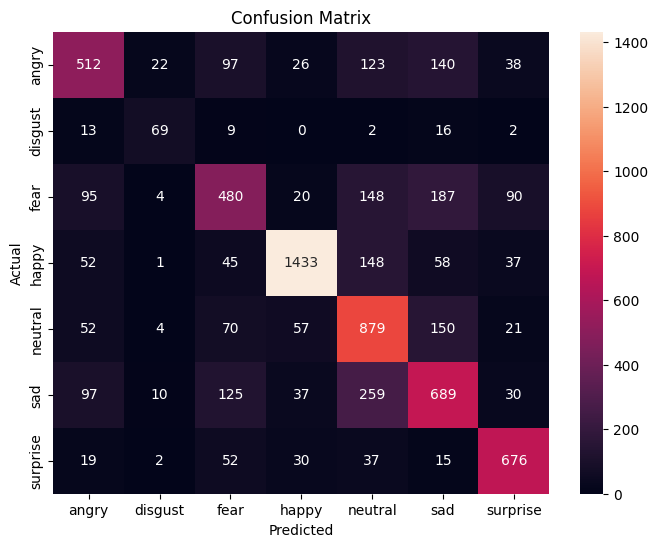


Classification Report:

              precision    recall  f1-score   support

       angry       0.61      0.53      0.57       958
     disgust       0.62      0.62      0.62       111
        fear       0.55      0.47      0.50      1024
       happy       0.89      0.81      0.85      1774
     neutral       0.55      0.71      0.62      1233
         sad       0.55      0.55      0.55      1247
    surprise       0.76      0.81      0.78       831

    accuracy                           0.66      7178
   macro avg       0.65      0.64      0.64      7178
weighted avg       0.67      0.66      0.66      7178



In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=val_dataset.classes,
            yticklabels=val_dataset.classes)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))
